In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers

2022-03-21 02:14:08.055810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 02:14:08.055846: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
data=yf.download('0700.hk')

[*********************100%***********************]  1 of 1 completed


In [4]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [5]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),k_features=10,forward=True,verbose=2,cv=5,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names.
backwardModel.fit(np.array(data.drop('Prediction',1)),data['Prediction'].values.ravel())

/tmp/ipykernel_6900/3525057244.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  backwardModel.fit(np.array(data.drop('Prediction',1)),data['Prediction'].values.ravel())
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  19 | elapsed:    2.4s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    2.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.2s finished

[2022-03-21 02:14:12] Features: 1/10 -- score: 0.2931269414085966[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    2.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.5s finished

[2022-03-21 02:14:16] Features: 2/10 -- score: 0.2830862017122979[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent 

SequentialFeatureSelector(estimator=RandomForestRegressor(), k_features=10,
                          n_jobs=-1, scoring='r2', verbose=2)

In [6]:
data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

/tmp/ipykernel_6900/3871399935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Prediction']=data['Close'].shift(-1)
/tmp/ipykernel_6900/3871399935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


,Open,High,Low,Close,Adj Close,Volume,6day MA,EMA12,MACD,TR,Prediction
Date,,,,,,,,,,,
2022-03-10,395.399994,398.799988,381.200012,385.000000,385.000000,24062703,393.833333,409.434724,-20.281971,17.599976,367.799988
2022-03-11,369.000000,375.399994,360.000000,367.799988,367.799988,48435608,385.333333,403.029380,-22.100892,25.000000,331.799988
2022-03-14,353.000000,359.600006,330.000000,331.799988,331.799988,66910165,373.433329,392.071012,-26.145906,37.799988,298.000000
2022-03-15,305.200012,333.200012,297.000000,298.000000,298.000000,118398276,358.433329,377.598548,-31.713412,36.200012,367.000000
2022-03-16,315.200012,370.799988,310.399994,367.000000,367.000000,107736861,355.733327,375.968002,-30.209739,72.799988,390.000000


In [7]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [8]:
X=sc.fit_transform(data.drop('Prediction',1))
Y = data["Prediction"].values.reshape(-1,1)
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(3830, 1, 10) (3830, 1) (426, 1, 10) (426, 1)


/tmp/ipykernel_6900/1768392262.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [9]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l1(1e-4)
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

2022-03-21 02:14:58.302066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-21 02:14:58.305046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 02:14:58.305349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-21 02:14:58.305561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-21 02:14:58.305631: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [10]:
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=5,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
y_pred = model_tech.predict(X_test)

Epoch 1/300
690/690 [==============================] - 5s 4ms/step - loss: 11832.4355 - val_loss: 414.1862
Epoch 2/300
690/690 [==============================] - 2s 3ms/step - loss: 362.3205 - val_loss: 88.4436
Epoch 3/300
690/690 [==============================] - 2s 3ms/step - loss: 124.3907 - val_loss: 52.7187
Epoch 4/300
690/690 [==============================] - 2s 3ms/step - loss: 78.0741 - val_loss: 51.8712
Epoch 5/300
690/690 [==============================] - 2s 3ms/step - loss: 64.0056 - val_loss: 50.7458
Epoch 6/300
690/690 [==============================] - 2s 3ms/step - loss: 57.1257 - val_loss: 45.0411
Epoch 7/300
690/690 [==============================] - 2s 3ms/step - loss: 52.8278 - val_loss: 45.1560
Epoch 8/300
690/690 [==============================] - 2s 3ms/step - loss: 50.0224 - val_loss: 47.1109
Epoch 9/300
690/690 [==============================] - 2s 3ms/step - loss: 48.2563 - val_loss: 48.0280
Epoch 10/300
690/690 [==============================] - 2s 3ms/step

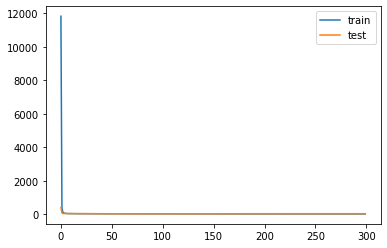

In [11]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

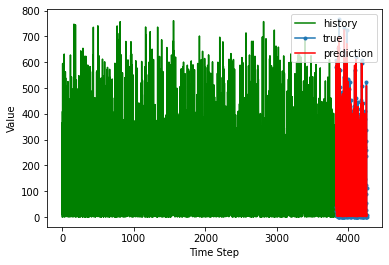

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

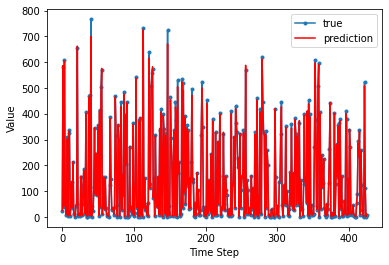

In [13]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [14]:
r2_score(y_test,y_pred)

0.998554277038263

In [15]:
mean_absolute_percentage_error(y_test,y_pred)

0.15416659535328

In [16]:
mean_squared_error(y_test,y_pred,squared=False)

6.698782216021621

In [17]:
x_val=data_val.drop('Prediction',1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)s

/tmp/ipykernel_6900/2328949661.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1)


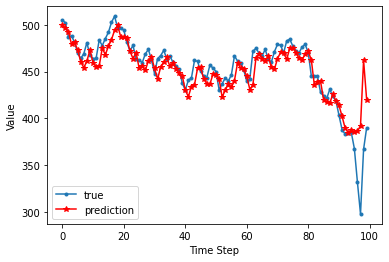

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [19]:
r2_score(y_val,y_val_pred)

0.7224984511629959

In [20]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.027006390692320456

In [21]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

18.536225300666366